<a href="https://colab.research.google.com/github/Niranjen99/Deep_learning_Assessment_3_RNN/blob/main/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import kagglehub

path = kagglehub.dataset_download("paultimothymooney/stock-market-data")

print("Path to dataset files:", path)

100%|██████████| 1.03G/1.03G [00:19<00:00, 57.4MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/paultimothymooney/stock-market-data/versions/74


In [2]:
import os

files = os.listdir(path)
print("Files in the dataset:", files)
for subdir, dirs, files in os.walk(path):
    for file in files:
        if file == "NVDA.csv":
            file_path = os.path.join(subdir, file)
            print("Found file:", file_path)

import pandas as pd

# Load the NVDA.csv file
nvidia_data = pd.read_csv(file_path)
print(nvidia_data.head())


Files in the dataset: ['stock_market_data']
Found file: /root/.cache/kagglehub/datasets/paultimothymooney/stock-market-data/versions/74/stock_market_data/nasdaq/csv/NVDA.csv
         Date       Low      Open     Volume      High     Close  \
0  22-01-1999  0.388021  0.437500  271468800  0.488281  0.410156   
1  25-01-1999  0.410156  0.442708   51048000  0.458333  0.453125   
2  26-01-1999  0.411458  0.458333   34320000  0.467448  0.417969   
3  27-01-1999  0.395833  0.419271   24436800  0.429688  0.416667   
4  28-01-1999  0.412760  0.416667   22752000  0.419271  0.415365   

   Adjusted Close  
0        0.376886  
1        0.416370  
2        0.384065  
3        0.382869  
4        0.381673  


        Date     Low    Open    Volume    High   Close  Adjusted Close
0 2016-01-04  8.0100  8.0725  35807600  8.1450  8.0925        7.913536
1 2016-01-05  8.1250  8.2450  49027200  8.3600  8.2225        8.040661
2 2016-01-06  7.7900  8.0875  44934400  8.1250  7.8825        7.708180
3 2016-01-07  7.4700  7.6850  64530400  7.7375  7.5700        7.402591
4 2016-01-08  7.3925  7.6675  39847200  7.6750  7.4075        7.243685
Filtered dataset contains 1749 rows.


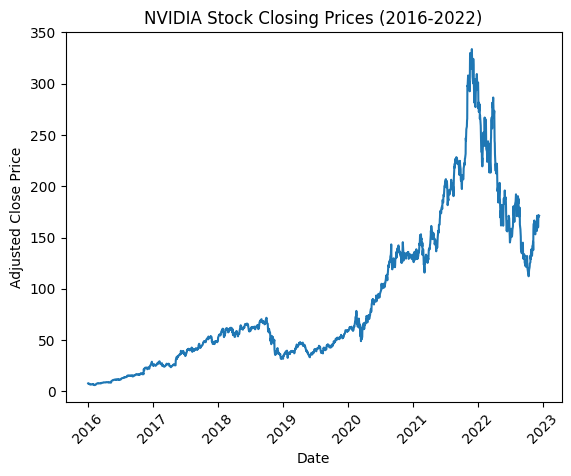

In [3]:
# Convert 'Date' column to datetime format with day-first order
nvidia_data['Date'] = pd.to_datetime(nvidia_data['Date'], format='%d-%m-%Y')

# Filter the dataset for the last 7 years (e.g., 2016-2022)
filtered_data = nvidia_data[(nvidia_data['Date'] >= '2016-01-01') & (nvidia_data['Date'] <= '2022-12-12')]

# Reset index after filtering
filtered_data = filtered_data.reset_index(drop=True)

# Display filtered data
print(filtered_data.head())
print(f"Filtered dataset contains {len(filtered_data)} rows.")

# Plot the closing price for visualization
import matplotlib.pyplot as plt

plt.plot(filtered_data['Date'], filtered_data['Adjusted Close'])
plt.title('NVIDIA Stock Closing Prices (2016-2022)')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.xticks(rotation=45)
plt.show()

In [4]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler


#Separate price features and volume
price_features = filtered_data[['Open', 'High', 'Low', 'Close']]
volume_feature = filtered_data[['Volume']]

# Initialize scalers for price and volume
price_scaler = MinMaxScaler()
volume_scaler = MinMaxScaler()

# Fit and transform the data
scaled_price = price_scaler.fit_transform(price_features)
scaled_volume = volume_scaler.fit_transform(volume_feature)

# Combine scaled price and volume
scaled_data = np.hstack((scaled_price, scaled_volume))

In [5]:
from sklearn.model_selection import train_test_split

#Creating Time-Series Sequences
def create_sequences(data, time_steps=30, future_steps=1):
    """
    Create input-output pairs for time series data.
    """
    X, y = [], []
    for i in range(len(data) - time_steps - future_steps + 1):
        X.append(data[i:i+time_steps])  # Past N days
        y.append(data[i+time_steps:i+time_steps+future_steps])  # Next M days
    return np.array(X), np.array(y)

time_steps = 30  # Past 30 days as input
future_steps = 1  # Predict the next day
X, y = create_sequences(scaled_data, time_steps, future_steps)

# Reshape y to (samples, features) for future_steps = 1
y = y.reshape(y.shape[0], -1)

# Split into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

print(f"Training data: {X_train.shape}, Validation data: {X_val.shape}, Testing data: {X_test.shape}")

Training data: (1203, 30, 5), Validation data: (258, 30, 5), Testing data: (258, 30, 5)


In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

#Building the LSTM Model
model_lstm = Sequential([
    LSTM(50, activation='tanh', input_shape=(time_steps, X.shape[2])),
    Dropout(0.2),  # Add dropout for regularization
    Dense(y.shape[1])  # Output layer (predict all features for the next day)
])

# Compile the model
model_lstm.compile(optimizer='adam', loss='mse')

#Training the Model
history_lstm = model_lstm.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32
)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - loss: 0.0111 - val_loss: 0.0047
Epoch 2/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0021 - val_loss: 0.0023
Epoch 3/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0018 - val_loss: 0.0020
Epoch 4/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0017 - val_loss: 0.0019
Epoch 5/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0016 - val_loss: 0.0013
Epoch 6/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0016 - val_loss: 0.0013
Epoch 7/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 8/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0016 - val_loss: 0.0012
Epoch 9/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0014 - val_loss: 0.0019
Epoch 10/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0014 - val_loss: 0.0017
Epoch 11/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0013 - val_loss: 9.9518e-04
Epoch 12/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss:

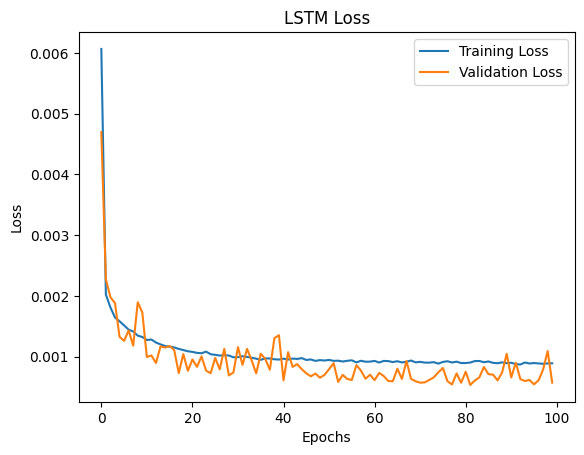

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Mean Squared Error (MSE): 0.0008
Root Mean Squared Error (RMSE): 0.0290
Mean Absolute Error (MAE): 0.0215


In [12]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Plot training and validation loss
plt.plot(history_lstm.history['loss'], label='Training Loss')
plt.plot(history_lstm.history['val_loss'], label='Validation Loss')
plt.title('LSTM Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluation of the Model
# Predict on test data
y_pred = model_lstm.predict(X_test)

# Compute evaluation metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")

In [13]:

# De-normalize predicted values
predicted_price = price_scaler.inverse_transform(y_pred[:, :4])  # First 4 columns are price features
predicted_volume = volume_scaler.inverse_transform(y_pred[:, 4:])  # Last column is volume

# Combine de-normalized price and volume for final output
predicted_denorm = np.hstack((predicted_price, predicted_volume))

# De-normalize actual test data
actual_price = price_scaler.inverse_transform(y_test[:, :4])
actual_volume = volume_scaler.inverse_transform(y_test[:, 4:])
actual_denorm = np.hstack((actual_price, actual_volume))

# Display Predictions for 5 Samples
features = ['Open', 'High', 'Low', 'Close', 'Volume']

# Show first 5 test samples with actual and predicted values
for i in range(5):
    actual_values = actual_denorm[i]
    predicted_values = predicted_denorm[i]

    print(f"Sample {i + 1}:")
    print("  Actual Values:")
    print(f"    Open: {actual_values[0]:.2f}, High: {actual_values[1]:.2f}, Close: {actual_values[3]:.2f}, Volume: {actual_values[4]:.2f}")
    print("  Predicted Values:")
    print(f"    Open: {predicted_values[0]:.2f}, High: {predicted_values[1]:.2f}, Close: {predicted_values[3]:.2f}, Volume: {predicted_values[4]:.2f}")
    print()

Sample 1:
  Actual Values:
    Open: 320.00, High: 321.29, Close: 306.93, Volume: 54432500.00
  Predicted Values:
    Open: 316.87, High: 323.52, Close: 316.13, Volume: 28174792.00

Sample 2:
  Actual Values:
    Open: 298.80, High: 302.41, Close: 300.37, Volume: 65893800.00
  Predicted Values:
    Open: 310.24, High: 316.68, Close: 309.43, Volume: 31989196.00

Sample 3:
  Actual Values:
    Open: 309.57, High: 324.49, Close: 324.27, Volume: 59305300.00
  Predicted Values:
    Open: 298.58, High: 303.73, Close: 297.09, Volume: 42708828.00

Sample 4:
  Actual Values:
    Open: 319.99, High: 322.90, Close: 318.26, Volume: 47555100.00
  Predicted Values:
    Open: 305.16, High: 310.62, Close: 304.20, Volume: 33927532.00

Sample 5:
  Actual Values:
    Open: 317.34, High: 322.05, Close: 304.90, Volume: 48850700.00
  Predicted Values:
    Open: 310.53, High: 316.70, Close: 310.11, Volume: 27779698.00



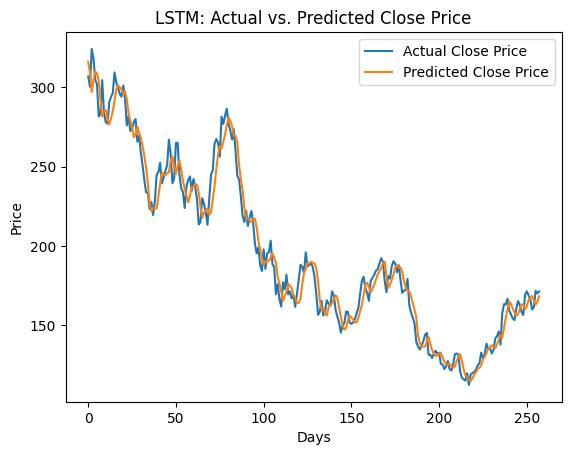

In [14]:
#Visualize Predictions for Close Price
plt.plot(actual_denorm[:, 3], label='Actual Close Price')  # Assuming Close is the 4th feature
plt.plot(predicted_denorm[:, 3], label='Predicted Close Price')
plt.title('LSTM: Actual vs. Predicted Close Price')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.show()

In [15]:
# Define a custom accuracy metric for test set
threshold = 0.05  # 5% error tolerance

# Calculate percentage difference
absolute_percentage_error = np.abs((y_pred - y_test) / y_test)

# Count the number of samples within the threshold
accurate_predictions = np.mean(absolute_percentage_error <= threshold, axis=0)  # Mean across all features

# Print custom accuracy for each feature
features = ['Open', 'High', 'Low', 'Close', 'Volume']
for i, feature in enumerate(features):
    print(f"Accuracy for {feature}: {accurate_predictions[i] * 100:.2f}%")

Accuracy for Open: 83.33%
Accuracy for High: 80.62%
Accuracy for Low: 79.07%
Accuracy for Close: 68.60%
Accuracy for Volume: 15.89%


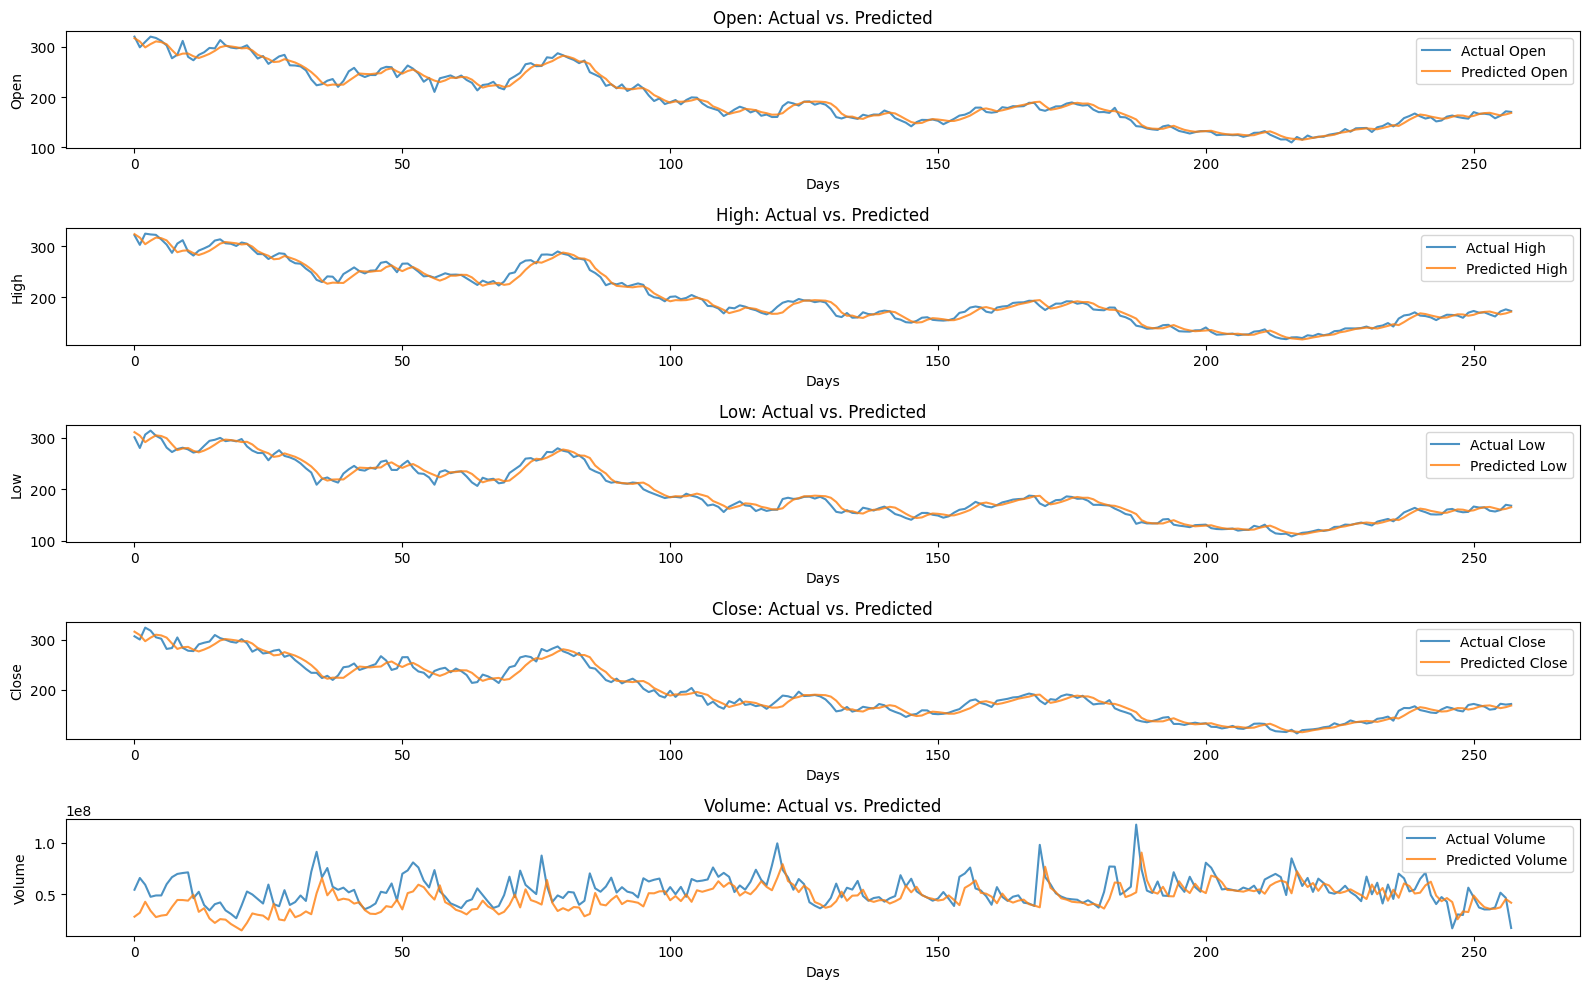

In [16]:
# Plot ground truth vs. predictions for all features
features = ['Open', 'High', 'Low', 'Close', 'Volume']
plt.figure(figsize=(16, 10))

# Iterate through all features and plot
for i, feature in enumerate(features):
    plt.subplot(len(features), 1, i + 1)
    plt.plot(actual_denorm[:, i], label=f'Actual {feature}', alpha=0.8)
    plt.plot(predicted_denorm[:, i], label=f'Predicted {feature}', alpha=0.8)
    plt.title(f'{feature}: Actual vs. Predicted')
    plt.xlabel('Days')
    plt.ylabel(feature)
    plt.legend()

# Adjust layout and show the plot
plt.tight_layout()
plt.show()